In [1]:
using Revise
using LinearAlgebra
using MatrixMarket
using EAMC
using SparseArrays
using Plots
using Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-13689275266494246510\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4438600201888162955\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-13689275266494246510\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
## load data
using MatrixMarket
data = cd("data/natalia191219") do 
    map(MatrixMarket.mmread, readdir())
    end;

In [3]:
## adjust diagonal to be a proper q matrix
using LinearAlgebra
qs = data
qs = map(qs) do q
    q = q
    q .- Diagonal(sum(q, dims=2)|>vec)
end;

In [175]:
## galerkin discretization of the eamc
using EAMC
dt = ones(length(qs))
dt[end] = 1000
tmax = length(qs)
g = @time EAMC.galerkin(qs[1:tmax], dt[1:tmax]);

  2.395098 seconds (844.16 k allocations: 4.330 GiB, 20.72% gc time)


┌ Warning: /Users/alex/Desktop/code/generators/src/embeddedspacetime.jl no longer exists, deleting all methods
└ @ Revise /Users/alex/.julia/packages/Revise/2NCCI/src/Revise.jl:543


In [176]:
sum(g,dims=2)

21600×1 Array{Float64,2}:
 1.0000000000000002
 0.9999999999999999
 1.0               
 1.0               
 0.9999999999999998
 1.0               
 0.9999999999999999
 0.9999999999999998
 1.0               
 1.0               
 0.9999999999999999
 1.0000000000000002
 0.9999999999999998
 ⋮                 
 0.9998040133236983
 0.999754209595439 
 0.9996991410576124
 0.9996977481799683
 0.999677152019069 
 0.9997277568157932
 0.9997673906620554
 0.9997877655505556
 0.9998235890968635
 0.9997899560707486
 0.9997378821790173
 0.9997586162543077

In [160]:
## create commitor systems

using SparseArrays
TT = g - I
nm = size(TT, 1)
n = 900
bnd = nm - n
for i in bnd+1 : nm
    TT[i,:] .= 0
    TT[i,i] = 1
end

In [161]:
## create commitor terminal condition
term = spzeros(nm,n)
term[nm-n+1:end, :] = sparse(I, n,n);

In [162]:
## solve commitors

@time cs = TT\collect(term)

 18.210210 seconds (3.68 k allocations: 1.465 GiB, 1.62% gc time)


21600×900 Array{Float64,2}:
 0.0149198  0.00727649  0.00422547  …  5.57341e-57  9.83519e-59  -0.0
 0.0136659  0.00663329  0.00384357     6.08358e-57  1.07344e-58  -0.0
 0.0170491  0.00827521  0.00479488     7.70791e-57  1.36003e-58   0.0
 0.0196988  0.00956052  0.00553936     9.55485e-57  1.68582e-58  -0.0
 0.0220383  0.0106947   0.00619614     1.20448e-56  2.12493e-58  -0.0
 0.0239452  0.0116191   0.00673127  …  1.55051e-56  2.73508e-58  -0.0
 0.0253258  0.0122893   0.00711943     2.06333e-56  3.63919e-58  -0.0
 0.0259777  0.0126097   0.00730585     2.8766e-56   5.07282e-58   0.0
 0.0259446  0.0126031   0.00730419     4.23363e-56  7.46485e-58  -0.0
 0.0258568  0.0125709   0.00728773     6.37867e-56  1.12459e-57  -0.0
 0.0261879  0.012737    0.00738459  …  9.76702e-56  1.72184e-57   0.0
 0.0291254  0.0141216   0.00817477     9.11213e-56  1.60695e-57  -0.0
 0.0361121  0.0173562   0.0100054      6.90591e-56  1.21921e-57  -0.0
 ⋮                                  ⋱                         

In [163]:
cc = reshape(cs, 30, 30, 24, 30, 30)

30×30×24×30×30 Array{Float64,5}:
[:, :, 1, 1, 1] =
 0.0149198    0.0132138    0.0119348    …  0.28987   0.285396  0.277527
 0.0136659    0.0136511    0.0131043       0.274478  0.274472  0.269966
 0.0170491    0.0169287    0.0159902       0.229583  0.243423  0.245534
 0.0196988    0.0194263    0.0180837       0.18482   0.206831  0.216502
 0.0220383    0.0214433    0.0196604       0.164127  0.176796  0.188697
 0.0239452    0.0229066    0.0203723    …  0.151621  0.157671  0.165188
 0.0253258    0.0234065    0.0197808       0.146035  0.147393  0.151865
 0.0259777    0.0225702    0.0181243       0.143921  0.143647  0.145046
 0.0259446    0.0209249    0.0164129       0.143123  0.143288  0.143111
 0.0258568    0.0195041    0.015016        0.141692  0.142636  0.142406
 0.0261879    0.0195038    0.0154441    …  0.139482  0.141114  0.141581
 0.0291254    0.022029     0.017967        0.137537  0.139594  0.140816
 0.0361121    0.0279415    0.0215583       0.136159  0.138361  0.140086
 ⋮           

In [171]:
using Plots
@manipulate for x=slider(1:30, 15, label="x"), y=slider(1:30, 15, label="y"), t=slider(1:24, 1, label="t")
heatmap(cc[:,:,t,y,x], title="Commitor von (x=$x,y=$y,t=24) zum zeitpunkt t=$t")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["x"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 30,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
15, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/alex/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000012485ad10, Task (runnable) @0x000000012485ad10), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":15,\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"12508495365806064435\",\"id\":\"ob_251\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"12508495365806064435\",\"id\":\"ob_250\",\"type\":\"observable\"})};\n

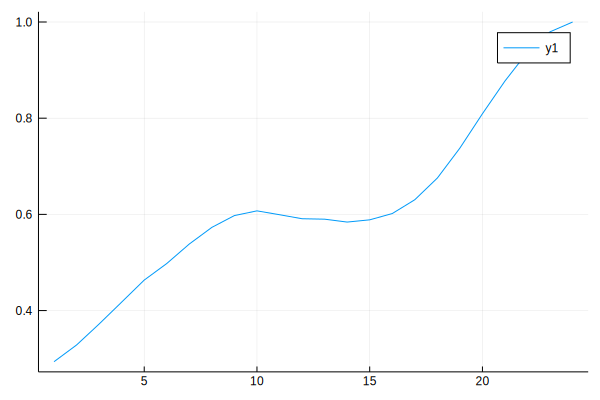

In [173]:
## starting with uniformly distributed mass at time t, how much of that mass is retained until t=24
# q: is this interpretation correct?
# a: cannot :D

plot([sum(cc[:,:,t,:,:])/900 for t=1:24])

In [88]:
## restrict clustering area to the center

xmin, xmax, ymin, ymax = 6,25,6,25
css = reshape(cc[xmin:xmax, ymin:ymax, 12, xmin:xmax, ymin:ymax], 20*20*1, 20*20)
#css = css ./ sqrt.(sum(css, dims=1))

overlap = css' * css
overlap = overlap - Diagonal(T)
overlap = overlap ./ sum(overlap, dims=2)

400×400 Array{Float64,2}:
 0.0         0.0292268   0.0197238   0.00731415  …  1.35414e-12  1.43974e-12
 0.0287468   0.0         0.0153005   0.00585689     1.39328e-12  1.48126e-12
 0.0185761   0.0146507   0.0         0.00419952     1.44527e-12  1.53644e-12
 0.00932539  0.0075921   0.00568512  0.0            1.49739e-12  1.59176e-12
 0.00424329  0.00371092  0.00316127  0.00185294     1.53161e-12  1.62808e-12
 0.00231816  0.00223947  0.0022033   0.00153583  …  1.5464e-12   1.64378e-12
 0.00230606  0.0022314   0.00219944  0.00153569     1.55067e-12  1.64832e-12
 0.00230463  0.00223144  0.0022009   0.00153741     1.55604e-12  1.65404e-12
 0.00229438  0.00222447  0.00219752  0.00153737     1.56262e-12  1.66103e-12
 0.00230911  0.00223734  0.00220803  0.00154278     1.57205e-12  1.67106e-12
 0.00225852  0.00219851  0.00218276  0.00153469  …  1.58052e-12  1.68006e-12
 0.0021613   0.00212261  0.00213169  0.00151675     1.58821e-12  1.68824e-12
 0.00203194  0.00202101  0.00206251  0.0014917    

In [89]:
include("src/pccap.jl")
nc = 4
p = pccap(overlap, nc)
# now sort by cluster size
p = p[:,sortperm(sum(p, dims=1)|>vec, rev=true)]

400×4 Array{Float64,2}:
 -7.18102e-17  0.015566   0.014878   0.969556  
  0.0645803    0.022796   0.0244433  0.88818   
  0.265297     0.0307867  0.0320124  0.671904  
  0.55691      0.0454131  0.0456639  0.352013  
  0.765737     0.0551242  0.0546418  0.124497  
  0.848988     0.0587703  0.0579703  0.034271  
  0.849775     0.0585925  0.0577327  0.0338993 
  0.850309     0.0583069  0.0573779  0.0340058 
  0.85135      0.0579978  0.0569895  0.0336624 
  0.851705     0.057435   0.0563233  0.0345367 
  0.854614     0.0572058  0.0559986  0.0321814 
  0.85935      0.0572235  0.0559244  0.0275016 
  0.865315     0.0574438  0.056059   0.0211819 
  ⋮                                            
  0.883543     0.0563123  0.0557311  0.00441337
  0.881522     0.0573373  0.0567447  0.00439612
  0.88353      0.0561818  0.0554721  0.0048163 
  0.884627     0.0555706  0.0547711  0.00503119
  0.884062     0.0558594  0.0549639  0.00511506
  0.880753     0.057581   0.0565744  0.00509156
  0.878975     0

In [90]:
centerinds = vcat(((xmin:xmax) .+ i*30 for i in ymin:ymax)...)
cl = reshape(cs[:, centerinds] * p, 30, 30, 24, nc)

30×30×24×4 Array{Float64,4}:
[:, :, 1, 1] =
 8.57099e-5   8.62718e-5   8.48785e-5   …  0.000249221  0.000185117
 0.000107526  0.000107637  0.000104456     0.0029272    0.00192566 
 0.000128124  0.000127351  0.00012185      0.0129236    0.00894243 
 0.000141254  0.000139785  0.000132557     0.02273      0.0155098  
 0.000151451  0.000148624  0.000139563     0.0284476    0.0201003  
 0.000158884  0.000154144  0.000141447  …  0.0322986    0.0242683  
 0.000163435  0.000154621  0.00013613      0.0357637    0.0293926  
 0.000164356  0.000148588  0.000125782     0.0390691    0.0350563  
 0.000161964  0.000138782  0.000115155     0.0389399    0.0373109  
 0.000159518  0.000130161  0.000106113     0.0372951    0.0372914  
 0.000159298  0.000128267  0.000107897  …  0.0350769    0.0362145  
 0.000171606  0.000139273  0.000119089     0.0330434    0.034825   
 0.000201944  0.000166449  0.000136115     0.0315089    0.0336015  
 ⋮                                      ⋱                          
 0.0

In [91]:
using Interact
c = 3
gr()
@manipulate for i = 1:24, c=1:nc
heatmap(log.(cl[:,:,i,c].+1), title="pccap on center, t=$i", clims=(0,.3))
    end

@manipulate for i = 1:24, c=1:nc
heatmap(cl[:,:,i,c], title="pccap on center, t=$i")
    end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 24,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
12, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/alex/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000126cf8fd0, Task (runnable) @0x0000000126cf8fd0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"7058360747526653667\",\"id\":\"ob_

In [14]:
C = reshape(cs, 900, 24, 900)

900×24×900 Array{Float64,3}:
[:, :, 1] =
 0.0223644  0.0026637  0.00724068  …  -0.0          -0.0          1.0
 0.028051   0.0130689  0.0219238       0.217802      0.385207     0.0
 0.0333909  0.027282   0.0349521       0.247039      0.157242     0.0
 0.0367428  0.0335978  0.0404901       0.173438      0.0720208    0.0
 0.0392919  0.0377735  0.0437864       0.10131       0.0292773    0.0
 0.0410873  0.0412072  0.0471266   …   0.0531285     0.0117853    0.0
 0.0421008  0.0439467  0.0500693       0.0313862     0.00625896   0.0
 0.0421396  0.0451357  0.0519687       0.0209853     0.00452414   0.0
 0.0412607  0.0443306  0.0523843       0.022807      0.00587053   0.0
 0.0402552  0.0425772  0.051213        0.0276967     0.00737772   0.0
 0.0396137  0.0411966  0.0498639   …   0.0311167     0.00789508   0.0
 0.0416093  0.0418744  0.0512538       0.0300709     0.00728996   0.0
 0.0465863  0.0448287  0.0562122       0.0244455     0.00533015   0.0
 ⋮                                 ⋱             

In [15]:
sum(C[:,:,:], dims=[1,3]) |> vec

24-element Array{Float64,1}:
 196.23297454357305
 215.57776693583315
 241.47820287908124
 267.75777869231547
 293.539483099305  
 313.02824727686925
 335.5092038344112 
 352.7464386212722 
 363.15631695534455
 365.90357091712366
 360.4820470388737 
 354.765135038029  
 354.30587926549805
 355.6550314377481 
 367.49878697510115
 387.76615803396834
 418.9511970825816 
 464.65403104177375
 526.1987359366279 
 597.1796479639529 
 670.5328180277235 
 739.4766719409444 
 803.9711323809041 
 900.0             

In [16]:
@manipulate for t=1:24
    reshape(sum(g, dims=2), 30, 30, 24)[:,:,t] |> heatmap
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["t"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 24,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
12, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/alex/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000001276d1d50, Task (runnable) @0x00000001276d1d50), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"3368888787597294754\",\"id\":\"ob_

In [17]:
@manipulate for t=1:24 
    -diag(Diagonal(qs[t])) |> collect |> x->reshape(x, 30, 30) |> x->heatmap(x, clims=(0,30))
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["t"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 24,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
12, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/alex/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000128094b50, Task (runnable) @0x0000000128094b50), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"8478878030647380722\",\"id\":\"ob_

In [18]:
?EAMC.myquiver

No documentation found.

`EAMC.myquiver` is a `Function`.

```
# 2 methods for generic function "myquiver":
[1] myquiver(f::EAMC.Flow, t) in EAMC at /Users/alex/Desktop/code/generators/src/processes/continuity.jl:57
[2] myquiver(xs, ys, u) in EAMC at /Users/alex/Desktop/code/generators/src/processes/continuity.jl:43
```


In [19]:
reshape(qs[1], 30, 30, 30, 30)

30×30×30×30 reshape(::SparseMatrixCSC{Float64,Int64}, 30, 30, 30, 30) with eltype Float64:
[:, :, 1, 1] =
 -4.61403  7.43317  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0      0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0      0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0      0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0      0.0  0.0  0.0  0.0     0.0 

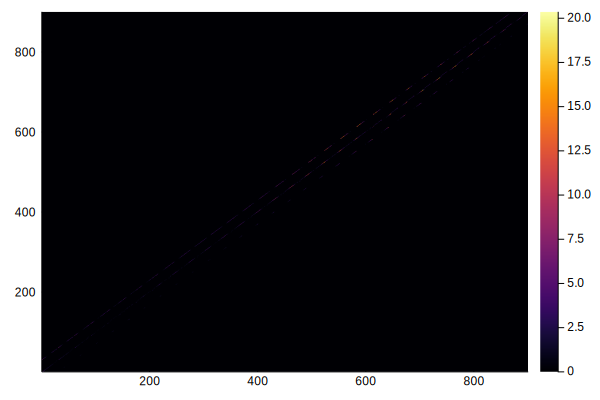

In [20]:
heatmap(data[1])

In [21]:
@manipulate for i=1:24
    reshape(ones(900)' *data[i], 30, 30) |> heatmap
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 24,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
12, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/alex/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000012573d450, Task (runnable) @0x000000012573d450), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"12842475789240701266\",\"id\":\"ob

In [22]:


dt = 0.1
Ps = [exp(dt*qs[t]|>collect) for t=1:24]
P=prod(Ps)

900×900 Array{Float64,2}:
 0.062925     0.211302     0.280164     …  2.26277e-104  2.17296e-105
 0.0408372    0.158958     0.250606        1.0505e-102   1.00881e-103
 0.021429     0.101492     0.202758        4.89646e-101  4.7021e-102 
 0.0119569    0.0648428    0.154523        2.48293e-99   2.38437e-100
 0.00660619   0.040055     0.110791        1.39218e-97   1.33692e-98 
 0.00342806   0.0229954    0.0729793    …  8.12146e-96   7.79908e-97 
 0.00180497   0.0131233    0.0466486       4.89086e-94   4.69672e-95 
 0.00111913   0.00827453   0.0312872       3.04593e-92   2.92502e-93 
 0.000913022  0.00612088   0.0228459       1.91806e-90   1.84192e-91 
 0.00077459   0.00459522   0.016497        1.1079e-88    1.06392e-89 
 0.000547225  0.00296154   0.0103124    …  5.86122e-87   5.62854e-88 
 0.000242296  0.00129006   0.00467336      2.16909e-88   2.08299e-89 
 7.63488e-5   0.000398068  0.00153285      3.46351e-91   3.32602e-92 
 ⋮                                      ⋱                       

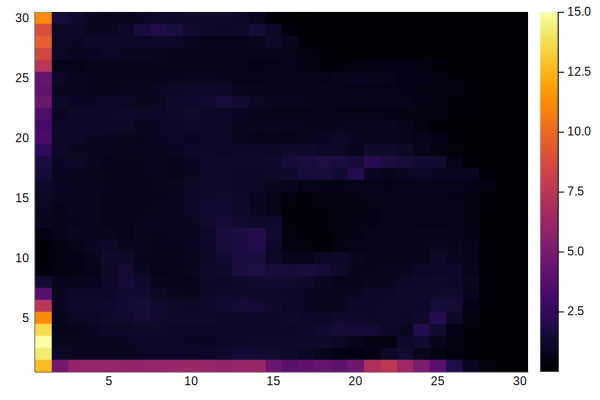

In [23]:
ones(900)' * P |> x->reshape(x, 30,30) |> heatmap